First we import the processed df from notebook 1.

In [136]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_pickle('/content/processed_test.pkl')
df_test = pd.read_pickle('/content/processed_train.pkl')

In [50]:
df_train

,label,tokens
0,0,"[love, scifi, willing, put, lot, scifi, movies..."
1,0,"[worth, entertainment, value, rental, especial..."
2,0,"[totally, average, film, semialright, action, ..."
3,0,"[star, rating, saturday, night, friday, night,..."
4,0,"[first, let, say, havent, enjoyed, van, damme,..."
...,...,...
24995,1,"[got, around, seeing, monster, man, yesterday,..."
24996,1,"[got, part, competition, prize, watched, reall..."
24997,1,"[got, monster, man, box, set, three, films, ma..."
24998,1,"[five, minutes, started, feel, naff, looking, ..."


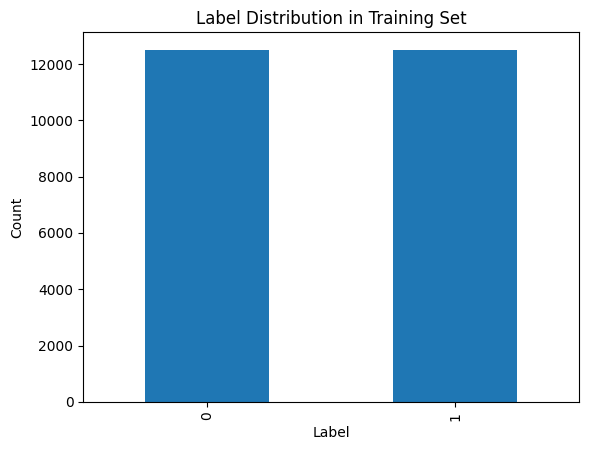

In [55]:
import matplotlib.pyplot as plt
df_train['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Now we can do representation using word2vec.

In [4]:
import gensim
from gensim.models import Word2Vec
import numpy as np

In [5]:
# Create the Word2Vec model
word2vec_model = Word2Vec(sentences=df_train['tokens'], vector_size=100, window=5, min_count=5)

In [6]:
# Save the model
# word2vec_model.save("word2vec_model")

In [7]:
# Function to get the average embedding for a document
def get_average_word2vec(tokens, model, vector_size):
    vector = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
            count += 1
    # Return the average
    if count > 0:
        vector /= count
    return vector

In [8]:
# Apply the function to get Word2Vec embeddings for each document
train_embeddings = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in df_train['tokens']])
test_embeddings = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in df_test['tokens']])

In [9]:
print("Train Embeddings Shape:", train_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)

Train Embeddings Shape: (25000, 100)
Test Embeddings Shape: (25000, 100)


In [131]:
print(train_embeddings[0])  # checking if embedded properly

[-0.44564767  0.36771587 -0.28497259 -0.28004604 -0.08882533 -0.07439551
  0.28621019  0.89980223 -0.18276253 -0.33671404 -0.0157368  -0.71142449
 -0.27431646  0.17635644 -0.01677777  0.129473    0.36447977 -0.15929282
  0.04428485 -0.82255666 -0.27312853  0.12539765  0.1508015   0.15594787
 -0.31076709  0.15650573 -0.20487661 -0.45677426 -0.02944552  0.07529268
  0.42984767 -0.15496024  0.31706813 -0.53234648 -0.07303941  0.48355953
  0.35570675  0.37718539  0.0136709  -0.17693345  0.13310405 -0.35157822
 -0.54817875  0.23972066  0.41353582  0.18655088 -0.31367216 -0.02687264
  0.4523485   0.1393851  -0.19746892  0.32805914 -0.04500911  0.29922239
 -0.50984741  0.13610946 -0.15254923 -0.24142543 -0.31537394  0.47146534
  0.03161711  0.15455771  0.23141484  0.27704873 -0.39446184  0.24999457
 -0.25783341  0.46923384 -0.13168786 -0.09457624  0.02283458  0.2815261
 -0.12137061  0.49380249  0.6680341  -0.18021869 -0.01397241  0.09942753
  0.28713291 -0.24061214 -0.22511777 -0.02797868 -0.

Now we split the train data into training and validation sets. We alrady have test data which is left untouched.

In [11]:
from sklearn.model_selection import train_test_split

# Split train_embeddings into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_embeddings,  # features from our Word2Vec embeddings for train data
    df_train['label'],
    test_size=0.2,      # 80-20 split
    random_state=42     # for reproducibility
)

In [12]:
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (20000, 100)
Validation set size: (5000, 100)


We will try logistic regression, random forest and xgboost and see how they each performs.

**1. Logistic Regression:**

In [13]:
from sklearn.linear_model import LogisticRegression


In [14]:
# Initialize our Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fitting the model on the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [34]:
# saving the model
import pickle

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.8086
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2515
           1       0.80      0.82      0.81      2485

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000

Confusion Matrix:
[[1998  517]
 [ 440 2045]]


We will try Random Forest now.

**2. Random Forest:**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculate accuracy
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)

print(f"Validation Accuracy (Random Forest): {accuracy_rf}")
print("Classification Report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_val, y_val_pred_rf))

Validation Accuracy (Random Forest): 0.789
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2515
           1       0.78      0.80      0.79      2485

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000

Confusion Matrix (Random Forest):
[[1953  562]
 [ 493 1992]]


Finally we will try XGBoost

**3. XGBoost:**

In [24]:
import xgboost as xgb

In [25]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [26]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 6,                  # max depth
    'learning_rate': 0.1,            # learning rate
    'n_estimators': 100,             # number of trees
    'seed': 42
}

In [27]:
# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')])

[0]	eval-error:0.29360
[1]	eval-error:0.26880
[2]	eval-error:0.26900
[3]	eval-error:0.26420
[4]	eval-error:0.25780
[5]	eval-error:0.25380


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	eval-error:0.25160
[7]	eval-error:0.25160
[8]	eval-error:0.24540
[9]	eval-error:0.24320
[10]	eval-error:0.24020
[11]	eval-error:0.23840
[12]	eval-error:0.23480
[13]	eval-error:0.23540
[14]	eval-error:0.23100
[15]	eval-error:0.23180
[16]	eval-error:0.23080
[17]	eval-error:0.22900
[18]	eval-error:0.22800
[19]	eval-error:0.22540
[20]	eval-error:0.22700
[21]	eval-error:0.22400
[22]	eval-error:0.22200
[23]	eval-error:0.22320
[24]	eval-error:0.22000
[25]	eval-error:0.21800
[26]	eval-error:0.21900
[27]	eval-error:0.21700
[28]	eval-error:0.21600
[29]	eval-error:0.21700
[30]	eval-error:0.21720
[31]	eval-error:0.21740
[32]	eval-error:0.21600
[33]	eval-error:0.21480
[34]	eval-error:0.21420
[35]	eval-error:0.21460
[36]	eval-error:0.21540
[37]	eval-error:0.21480
[38]	eval-error:0.21360
[39]	eval-error:0.21420
[40]	eval-error:0.21280
[41]	eval-error:0.21320
[42]	eval-error:0.21140
[43]	eval-error:0.21020
[44]	eval-error:0.20980
[45]	eval-error:0.20920
[46]	eval-error:0.21000
[47]	eval-error:0.21

In [28]:
# Predict on the validation set
y_val_pred_xgb = bst.predict(dval)
y_val_pred_xgb = (y_val_pred_xgb > 0.5).astype(int)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)

print(f"Validation Accuracy (XGBoost): {accuracy_xgb}")
print("Classification Report (XGBoost):")
print(classification_report(y_val, y_val_pred_xgb))
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_val, y_val_pred_xgb))

Validation Accuracy (XGBoost): 0.7996
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2515
           1       0.79      0.81      0.80      2485

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000

Confusion Matrix (XGBoost):
[[1997  518]
 [ 484 2001]]


**Model Comparison and Summary:**

The Logistic Regression model achieved a validation accuracy of 81%, with balanced precision and recall across both negative and positive sentiment classes. The Random Forest model performed slightly worse with a validation accuracy of 78.9%, showing similar class balance but with a lower overall performance. The XGBoost model performed similarly, with a validation accuracy of 79.96%, maintaining good balance between precision and recall for both classes.

Overall, we can simply use Logistic Regression as it is a simple model.
We can use XGBoost or Random Forest as well, we can do more parameter tuning in the future if needed.

We can make a pipeline and test how it works on unseen sample data. For now we can test in this notebook.

In [56]:
# import the necessary libraries

import string
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [57]:
# Remove punctuation
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

# Tokenize
def tokenize(text):
    return text.split()

# Remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Preprocess function: lowercase, remove punctuation, tokenize, remove stopwords
def preprocess_text(text):
    text = text.lower()
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    return tokens

In [116]:
def predict_sentiment(text, word2vec_model, model, vector_size=100):
    # Preprocess the text sample
    tokens = preprocess_text(text)

    # Get the Word2Vec embedding for the sample
    embedding = get_average_word2vec(tokens, word2vec_model, vector_size)

    # Convert the embedding to a 2D array format suitable for prediction
    embedding = embedding.reshape(1, -1)  # Reshape for a single sample

    # Get the probability prediction
    prediction_prob = model.predict_proba(embedding)

    # Extract the probability for the positive class
    positive_prob = prediction_prob[0][1]  # probability for class 1

    # Predict sentiment based on 50% threshold
    sentiment = 1 if positive_prob > 0.5 else 0  # if prediction > 0.5, classify as positive

    # Print the predicted sentiment and the prediction probability
    print(f"Predicted Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")
    print(f"Prediction Probability: {positive_prob * 100:.2f}%")

    return sentiment, positive_prob

In [132]:
print("Example text 1: Logistic Regression")
sample_text = "Oh my god, the actor is so amazing here."

# Predict the sentiment (1 for positive, 0 for negative)
predicted_sentiment = predict_sentiment(sample_text, word2vec_model, model)

Example text 1: Logistic Regression
Predicted Sentiment: Positive
Prediction Probability: 59.23%


In [134]:
print("Example text 1: Random Forest")
sample_text = "Oh my god, the actor is so amazing here."

# Predict the sentiment (1 for positive, 0 for negative)
predicted_sentiment = predict_sentiment(sample_text, word2vec_model, rf_model)

Example text 1: Random Forest
Predicted Sentiment: Positive
Prediction Probability: 58.00%


In [129]:
print("Example text 2:")
sample_text = "I would've been able to understand everything in this complicated story - if I could've HEARD half of the dialogue. I watched parts of this film in three different environments, and even in the best one way too many important lines were simply unintelligble. Since this is apparently a conscious choice by the director, I doubt I'll ever watch another Nolan film."

# Predict the sentiment (1 for positive, 0 for negative)
predicted_sentiment = predict_sentiment(sample_text, word2vec_model, model)
print("IMDB Rating: 1, negative")

Example text 2:
Predicted Sentiment: Negative
Prediction Probability: 25.32%
IMDB Rating: 1, negative


In [130]:
print("Example text 3:")
sample_text = "Some people can say this is too complicated moive and there is no feeling at all, after watching this. But didn't watch any moive that ends connection between two characters like this. So it is the best end I ever watched. Remember the how Vin diesel and Paul walker end their relationship by looking at each other and go different paths at a road junction. In this film it would be like Protagonist and neil meets at a same road in different direction, and neils know this is the end of their relationship and Protagonist knows he will again meet him at some distance.... Not only the end, the plot is superb. It's like I watch a half of a movie with one half my brain and other part of my brain knows what is going to happen in the other pat. In deeper sense..Neil and Protagonist is not the different characters. They are the reflections of a same person. The best moive I ever watched. Thank you Christopher Nolan.. I would love to see a series based on the world of Tenet."

# Predict the sentiment (1 for positive, 0 for negative)
predicted_sentiment = predict_sentiment(sample_text, word2vec_model, model)

print("IMDB Rating: 10, positive")

Example text 3:
Predicted Sentiment: Positive
Prediction Probability: 80.55%
IMDB Rating: 10, positive
